<a href="https://colab.research.google.com/github/MananShukla7/Colab-Notebook/blob/main/05_Custom_Datasets_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

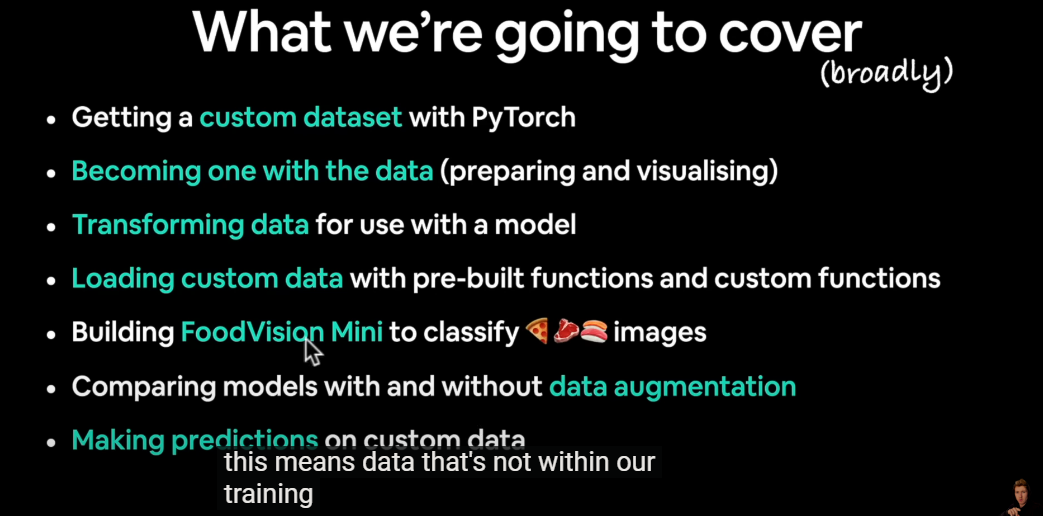

##0. Setting up the Pytorch And importing libraries

In [1]:
import torch
from torch import nn
torch.__version__

'1.13.1+cu116'

In [2]:
#Setting up the device agnostics

device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

##1. Getting our data

Our dataset is the subset of the food101 dataset

Our dataset starts with 101 different class of food and 1000 images per class(750 training, 250 testing)

why do this??

Start smol , test and then scale!!

In [3]:
import requests
import zipfile
from pathlib import Path

data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi"

#if the image folder doesnt exist, download it and prepare it...

if image_path.is_dir():
  print(f"{image_path} directory already exists..skipping download")
else:
  print(f"{image_path} doesn't exist!,Creating one")
  image_path.mkdir(parents=True,exist_ok=True)

#Download
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("downlaoding the pizza,steak and sushi data ....")
  f.write(request.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip") as zip_ref:
  print("UNzipping the data....")
  zip_ref.extractall(image_path) #PosixPath('data/pizza_steak_sushi')

data/pizza_steak_sushi doesn't exist!,Creating one
downlaoding the pizza,steak and sushi data ....
UNzipping the data....


In [4]:
image_path  

PosixPath('data/pizza_steak_sushi')

## 2. Becoming one with the data!

In [5]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""

  for dirpath,dirnames,filenames in os.walk(dir_path): 
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in'{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in'data/pizza_steak_sushi'.
There are 3 directories and 0 images in'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in'data/pizza_steak_sushi/test/steak'.


In [7]:
train_dir=image_path/"train"
test_dir=image_path/"test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

##2.1 visualising an image

Let's wrote some code to:
1. Get all of the ikage paths
2. Pick a random image path using python's random.choice()
3. Get the image class name `pathlib.Path.parent.stem`
4.Since we're working with images,let's open it with python PIL 
5. We'll then show the image and print the metadeta


sushi
Random image path:data/pizza_steak_sushi/test/sushi/1600999.jpg
Image class:sushi
Image heightL 484
Image width: 512


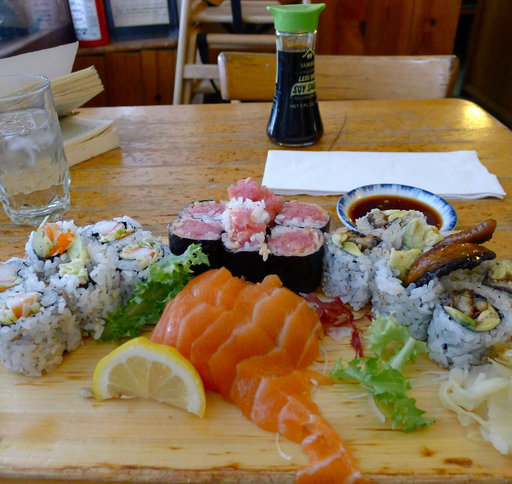

In [8]:
import random
from PIL import Image
# Set seed
# random.seed(42)


image_path_list=list(image_path.glob("*/*/*.jpg"))

# image_path_list

#2. Pick a random image path

random_image_path=random.choice(image_path_list)

random_image_path

#3. Get image flass from path name 
# (the image class is the name of the directory where the image is stored)
image_class=random_image_path.parent.stem
print(image_class)

#4.open image using PIL

img=Image.open(random_image_path)
#5. Print metadata 
print(f"Random image path:{random_image_path}")
print(f"Image class:{image_class}")
print(f"Image heightL {img.height}")
print(f"Image width: {img.width}")
img

In [9]:
image_path

PosixPath('data/pizza_steak_sushi')

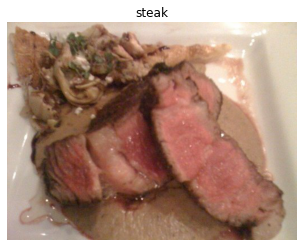

(384, 512, 3)


In [10]:
#Try to visualize and image with matplotlib

import matplotlib.pyplot as plt

img_list=list(image_path.glob("*/*/*.jpg"))

random_c=random.choice(img_list)
random_c
titlee=random_c.parent.stem
x=plt.imread(random_c)
plt.imshow(x.squeeze());
plt.title(titlee)
plt.axis(False)
plt.show();
print(x.shape) #pytorch oder is cwh-> color width height

In [11]:
x

array([[[185, 172, 155],
        [189, 174, 155],
        [191, 174, 154],
        ...,
        [214, 201, 182],
        [213, 200, 181],
        [213, 200, 181]],

       [[187, 174, 157],
        [192, 177, 158],
        [194, 177, 157],
        ...,
        [215, 202, 183],
        [214, 201, 182],
        [214, 201, 182]],

       [[190, 177, 160],
        [196, 181, 162],
        [199, 182, 162],
        ...,
        [214, 201, 182],
        [213, 200, 181],
        [214, 201, 182]],

       ...,

       [[178, 158, 149],
        [179, 159, 150],
        [179, 159, 152],
        ...,
        [174, 168, 144],
        [173, 167, 143],
        [170, 164, 140]],

       [[178, 158, 149],
        [179, 159, 150],
        [181, 161, 154],
        ...,
        [175, 169, 145],
        [173, 167, 143],
        [169, 163, 139]],

       [[175, 155, 146],
        [177, 157, 150],
        [179, 159, 152],
        ...,
        [173, 167, 143],
        [170, 164, 140],
        [165, 159, 135]]

### 3. Transforming the data

Befire we can use our image data with PyTorch:
1. Turn your target data into tensors(in our case,numerical rep of our data)
2. Turn it into a `torch.utils.data.Datasets` to `torch.utils.data.DataLoader`.


In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import ToPILImage
import torchvision.transforms.functional as F


### 3.1 Transforming data with `torchvision.transforms`

In [13]:
#Write a transform 
data_transform=transforms.Compose([
    #Resize our img
    transforms.Resize(size=(64,64)),
    #Flip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #Transform the img to tensor
    transforms.ToTensor()
])

In [14]:
imgg=F.to_pil_image(x)

In [15]:
new_img=data_transform(imgg)

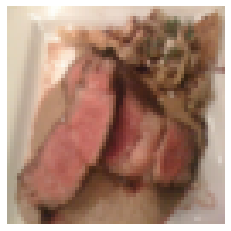

In [16]:
# y=new_img.numpy().squeeze()
# y.shape
plt.imshow(new_img.permute(1,2,0));
plt.axis(False);

In [17]:
## Making a function for visualising our tranformed and original data

def plot_transformed_images(image_paths:list,transform,n=3,seed=None):
  """
  Selects random images from the path of images and loads/transforms them then
  plots the original vs the transformed images to see the difference visually!!
  """
  if seed:
    random.seed(seed)
  random_image_paths=random.sample(image_paths,k=n)
  for image_path in random_image_paths:
      with Image.open(image_path) as f:
        plt.figure(figsize=(12,10))

        fig,ax=plt.subplots(1,2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original\nSIze:{f.size}")
        ax[0].axis(False);

        #Transforms and plot target image
        transformed_image=transform(f) #NEeed to convert the cwh to whc for the matplotlib
        ax[1].imshow(transformed_image.permute(1,2,0))
        ax[1].set_title(f"Transformed \nShape: {transformed_image.shape}")
        ax[1].axis(False);

        fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)



  

<Figure size 864x720 with 0 Axes>

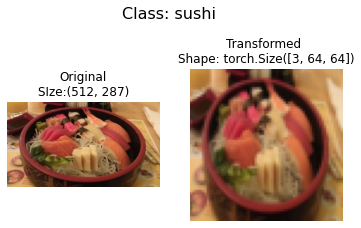

<Figure size 864x720 with 0 Axes>

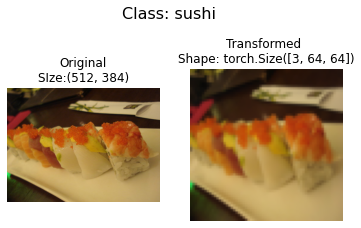

<Figure size 864x720 with 0 Axes>

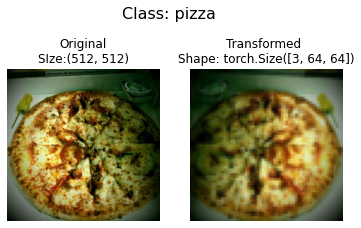

In [18]:
plot_transformed_images(img_list,data_transform,n=3)

## 4. Opt:1 Loading the image data using the `ImageFolder`

We can load image classification data using the `torchvision.datasets.ImageFolder`

In [23]:
#Use imagefolder to create dataset(s)

from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transform, # a transform for the data
                                target_transform=None)

test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transform)



In [24]:
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [25]:
#Get class names as list
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [26]:
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [27]:
#check the length of our data

len(train_data),len(test_data)

(225, 75)

In [62]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [59]:
%%capture
train_data[0]

In [58]:
img,label=train_data[0][0],train_data[0][1]

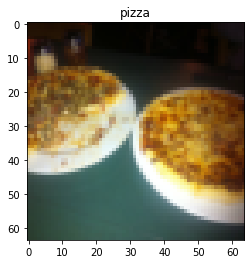

In [48]:
plt.imshow(train_data[0][0].permute(1,2,0))
plt.title(class_names[label[train_data[0][1]]]);

In [53]:
print(f"Image tensor:\n {train_data[0][0]}")
print(f"Image label: {train_data[0][1]}")
print(f"Image dtype: {train_data[0][0].dtype}")
print(f"Image shape: {train_data[0][0].shape}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

In [61]:
#Changing the c w h  to w h c for visualization
img_permute=img.permute(1,2,0)
img_permute.shape

torch.Size([64, 64, 3])

In [30]:
from torch.utils.data import DataLoader

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=32,
                            shuffle=True)

test_dataloader=DataLoader(dataset=test_data,
                            batch_size=32,
                            shuffle=True)


In [32]:
train_dataloader.dataset

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [33]:
img,label=next(iter(train_dataloader))

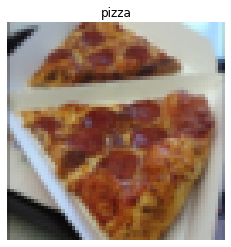

In [43]:
n=0
for i in img:
  
  plt.imshow(i.permute(1,2,0))
  plt.title(class_names[label[n]])
  plt.axis(False)
  n+=1